# Naive Bayes from scratch

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

# pytorch
import torch
import torchvision
import torch.nn as nn

from torch.utils.data import DataLoader, random_split, Dataset

# train utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## Задание
### Оригинал

Добрый день. Следующая вторая лаба - Наивный Байесовский классификатор (на номер не смотрите, это порядковый номер, в котором я делал лабы сам). В качестве датасета используйте Fashion-MNIST (он есть в качестве встроенного в библиотеке scikit-learn, да и в других тоже имеется). Постарайтесь добиться точности хотя бы в 75%, хотя желательно все-таки свыше 80%. Данные крутите, как хотите, но максимальную точность классификации обеспечьте

- [доп материал с разьяснениями](./lab_task_materials/Lab_4_ML.docx)

### Переделано

- Наивный Байесовский классификатор
- В качестве датасета используйте Fashion-MNIST
- Точность 75%-80%

## Предварительные знания

### [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)

P(A | B) = P(B | A)*P(A) / P(B)
- P(A | B) is a conditional probability: the probability of event A occurring given that B is true. It is also called the **posterior probability** of A given B.
- P(B | A) is also a conditional probability: the probability of event B occurring given that A is true. It can also be interpreted as the **likelihood** of A given a fixed B.
- P(A) and P(B) are the probabilities of observing A and B respectively without any given conditions; they are known as the **marginal probability** or **prior probability**.


## Импортируем данные

### Import Fashion mnist

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    # train = True,
    # download = True,
    # transform = torchvision.transforms.Compose([
    #     torchvision.transforms.ToTensor()                                 
    # ])
)

In [3]:
train_set.data.shape

torch.Size([60000, 28, 28])

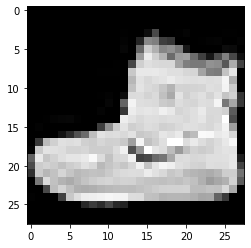

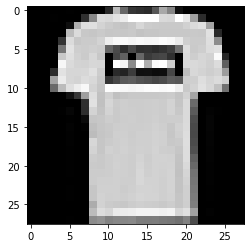

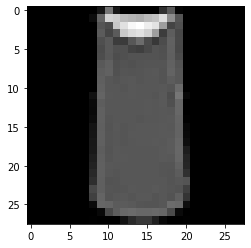

In [4]:
for image_data in train_set.data[:3]:
	plt.imshow(image_data, cmap="gray")
	plt.show()

In [28]:
X = train_set.data.numpy()
y = train_set.targets.numpy()

In [29]:
X.shape

(60000, 28, 28)

In [30]:
X = X.reshape(X.shape[0], X.shape[1]**2)
X.shape

(60000, 784)

## Sklearn Naive Bayes

In [31]:
model = GaussianNB()
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring=make_scorer(accuracy_score))

In [33]:
print(scores.mean())

0.58995


Дефолтный результат показывает точность около 58%. Попробуем преобразовать данные

In [49]:
def k_fold_validation(
		model_class, 
		X, 
		y, 
		cv=5, 
		model_params=None, 
		metric=None, 
		is_norm=True
	):
	assert metric != None, 'Metric should be not a None'
	if model_params == None:
		model_params = {}
	
	k_fold = KFold(n_splits=cv)
	k_fold.get_n_splits(X)

	scores = []
	for train_index, test_index in k_fold.split(X):
		model = model_class(**model_params)
		X_train, X_test = X[train_index], X[test_index]
		y_train, y_test = y[train_index], y[test_index]
		
		if is_norm:
			# normalize data
			scaler = StandardScaler()
			scaler.fit(X_train)
			X_train = scaler.transform(X_train)
			X_test = scaler.transform(X_test)
		
		model.fit(X_train, y_train)
		pred = model.predict(X_test)
		result = metric(y_test, pred)
		scores.append(result)

	scores = np.array(scores).mean()

	return scores

In [50]:
scores = k_fold_validation(
	GaussianNB, 
	X, 
	y, 
	cv=5, 
	model_params=None, 
	metric=accuracy_score,
	is_norm=False
)
print(f"GaussianNB Mean Error = {scores}")

GaussianNB Mean Error = 0.5904666666666667


Так как Fashion mnist это картинки, то глупо анализировать "сырые" данные такой моделью как GaussianNB.
Для начала нам необходимо сократить размерность этих данных.

## PCA

In [73]:
model = lambda : Pipeline([('PCA', PCA(n_components=60)), ('GaussianNB', GaussianNB())])
scores = k_fold_validation(
	model, 
	X, 
	y, 
	cv=5, 
	model_params=None, 
	metric=accuracy_score,
	is_norm=False
)
print(f"GaussianNB Mean Error = {scores}")

GaussianNB Mean Error = 0.7778833333333333


Как можно заметить простое сокращение размерности принесло существенный прирост в точности.
Теперь попробуем использовать более разумный подход. Попытаемся сформировать выразительные эмбединги при помощи сверточных нейронных сетей, а затем скормить эти эмбединги нашему наивному байесу.

## Create dataloaders

In [175]:
dataset_train = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)
dataset_test = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

class FashionMNISTDataset(Dataset):
    def __init__(self,
            transform=None, 
            target_transform=None,
            initial_dataset=None,
        ):

        super().__init__()
        self.initial_dataset = initial_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index: int):
        img = self.initial_dataset.data[index].type(torch.float32).reshape(1, 28, 28)
        target = self.initial_dataset.targets[index]
        
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.initial_dataset)

train_data = FashionMNISTDataset(initial_dataset=dataset_train)
test_data = FashionMNISTDataset(initial_dataset=dataset_test)

train_data, val_data = torch.utils.data.random_split(
    train_data, 
    [50000, 10000], 
    generator=torch.Generator().manual_seed(228),
)
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, )
test_dataloader = DataLoader(test_data, batch_size=batch_size,)


In [191]:
import torch
import wandb
from datetime import datetime
import shutil
import os
from importlib.machinery import SourceFileLoader
import importlib


class BaseExperiment:
    def __init__(
        self,
        model=None,
        dataloader_train=None,
        dataloader_valid=None,
        dataloader_test=None,
        loss_func_class=None,
        estimate_func_class=None,
        experiment_config=None,
        optimizer_class=None,
        sheduler_class=None,
        project_name=None,
        notebook_name=None,
        name_run="",
        model_description="",
    ):
        assert (
            notebook_name != None
        ), f"notebook_name should be valid filename, but get {notebook_name}"

        # datasets
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.dataloader_test = dataloader_test

        # wandb
        self.notebook_name = notebook_name
        self.project_name = project_name
        self.experiment_config = experiment_config
        self.wandb_run = None
        self.name_run = name_run
        self.model_description = model_description
        self.model_name = "pytorch_model"
        self.model_artifact = None

        self.optimizer_class = optimizer_class
        self.sheduler_class = sheduler_class
        self.loss_func_class = loss_func_class
        self.estimate_func_class = estimate_func_class

        self.model = model
        self.optimizer = None
        self.sheduler = None
        self.loss_func = None
        self.estimate_func = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device {self.device}")

        # prepare for experiment
        self.setup()
        self.unit_tests()

    def setup(self):
        self.model.to(self.device)
        self.optimizer = self.optimizer_class(
            self.model.parameters(), **self.experiment_config["optimizer"]
        )

        if self.sheduler_class != None:
            self.sheduler = self.sheduler_class(
                self.optimizer, **self.experiment_config["sheduler"]
            )

        self.loss_func = self.loss_func_class()
        self.estimate_func = self.estimate_func_class()

        # set model name
        date_time = self.get_date()
        self.model_name = f"{self.name_run}---{date_time}.pt"
        self.experiment_config["model_name"] = self.model_name

        # setup wandb
        # save model structure and weights to wandb
        self.model_artifact = wandb.Artifact(
            self.name_run,
            type="model",
            description=self.model_description,
            metadata=self.experiment_config,
        )

    def get_date(self):
        now = datetime.now()
        date_time = now.strftime("%m_%d_%Y__%H_%M_%S")
        return date_time

    def unit_tests(self):
        # test training
        X, y = next(iter(self.dataloader_train))
        X, y = X.to(self.device), y.to(self.device)
        pred = self.model(X)
        loss = self.loss_func(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # test valid
        X, y = next(iter(self.dataloader_valid))
        X, y = X.to(self.device), y.to(self.device)
        pred = self.model(X)
        test_loss = self.estimate_func(pred, y).item()
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        # initial validation
        self.model.eval()
        test_loss, correct = 0, 0
        num_batches = len(self.dataloader_valid)
        size = len(self.dataloader_valid.dataset)

        with torch.no_grad():
            for X, y in self.dataloader_valid:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.estimate_func(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print("Initial val = ", correct)

        print("tests ok")

    def train(self):
        # https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W%26B_Artifacts.ipynb#scrollTo=qrAWbBV1rd4I
        # если попытаться создать переменную чтобы не городить тут код возникает ошибка с wandb!
        with wandb.init(
            project=self.project_name,
            entity="dimweb",
            settings=wandb.Settings(
                start_method="thread",
                # symlink=False
            ),
            reinit=True,
            name=self.name_run,
            config=self.experiment_config,
            # sync_tensorboard=True
        ) as run:

            self.run = run

            # save model class
            self.save_model_class()

            # start train
            epochs = self.experiment_config["epochs"]
            for i in range(epochs):
                print(f"Epoch: {i}")
                self.train_steps()
                self.valid_steps()

            # sync model
            self.wandb_save_model()

            print(f"train end")

    def save_model_class(self):
        # save class
        model_class_name = self.experiment_config["model_class_name"]
        class_script_path_dest = f"{os.path.join(wandb.run.dir, model_class_name)}.py"
        class_script_path_src = f"./models/{model_class_name}.py"
        shutil.copy2(class_script_path_src, class_script_path_dest)
        self.model_artifact.add_file(class_script_path_dest)
        wandb.save(class_script_path_dest)

    def wandb_save_model(self):
        # wandb использует symlinks для того чтобы сохранять файлы
        # но из-за проблем с правами доступа возникает ошибка и модель нельзя сохранить
        # поэтому пришлось сохранять модель в дирректорию с самим запуском
        # https://docs.wandb.ai/guides/track/advanced/save-restore#example-of-saving-a-file-to-the-wandb-run-directory
        model_save_path = os.path.join(wandb.run.dir, self.model_name)
        torch.save(self.model.state_dict(), model_save_path)
        self.model_artifact.add_file(model_save_path)
        wandb.save(model_save_path)

        # save notebook
        notebook_path = os.path.join(wandb.run.dir, self.notebook_name)
        shutil.copy2(self.notebook_name, notebook_path)
        self.model_artifact.add_file(notebook_path)
        wandb.save(notebook_path)

        wandb.log_artifact(self.model_artifact)

    def train_steps(self):
        raise NotImplementedError("You need specify training steps")

    def valid_steps(self):
        raise NotImplementedError("You need specify valid steps")

    def load_model(self, artifact_name, additional_model_args={}):
        assert artifact_name != ""
        # for windows subsystem

        with wandb.init(project=self.project_name, job_type="inference"):
            model_artifact = wandb.use_artifact(artifact_name)
            model_dir = model_artifact.download()
            model_config = model_artifact.metadata
            model_path = os.path.join(model_dir, model_config["model_name"])
            # print(model_config)

            artifact_name = artifact_name.replace(":", "-")
            model_class_name = model_config["model_class_name"]
            model_script_path = f"./artifacts/{artifact_name}/{model_class_name}.py"
            # get module by path https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path?rq=1
            model_class = getattr(
                SourceFileLoader(model_class_name, model_script_path).load_module(),
                model_class_name,
            )

            model_args = model_config["model_args"]
            model = model_class(**model_args, **additional_model_args)

            model.load_state_dict(torch.load(model_path))
            self.model = model
            self.model.to(self.device)

    @staticmethod
    def static_load_model(artifact_name="", project_name="", additional_model_args={}):
        assert artifact_name != ""
        assert project_name != ""
        with wandb.init(project=project_name, job_type="inference"):
            model_artifact = wandb.use_artifact(artifact_name)
            model_dir = model_artifact.download()
            model_config = model_artifact.metadata
            model_path = os.path.join(model_dir, model_config["model_name"])

            model_class_name = model_config["model_class_name"]
            model_script_path = f"./artifacts/{artifact_name}/{model_class_name}.py"
            model_class = getattr(
                SourceFileLoader(model_class_name, model_script_path).load_module(),
                model_class_name,
            )

            model_args = model_config["model_args"]
            model = model_class(**model_args, **additional_model_args)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            model.load_state_dict(torch.load(model_path))

            return model

    def test(self, artifact_name="", model=None):
        raise NotImplementedError("You need specify test steps")


class Experiment(BaseExperiment):
    def __init__(self, **kwargs):
        super(Experiment, self).__init__(**kwargs)

    def train_steps(self):
        self.model.train()
        interval = self.experiment_config["check_interval"]

        for batch, (X, y) in enumerate(self.dataloader_train):
            # Send data to training device
            X, y = X.to(self.device), y.to(self.device)

            # Compute prediction error
            pred = self.model(X)
            loss = self.loss_func(pred, y)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.sheduler != None:
                self.sheduler.step()

            # Progress output
            if batch % interval == 0:
                wandb.log({"train_loss": loss.item()})

    def valid_steps(self):
        self.model.eval()
        test_loss, correct = 0, 0
        num_batches = len(self.dataloader_valid)
        size = len(self.dataloader_valid.dataset)

        with torch.no_grad():
            for X, y in self.dataloader_valid:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.estimate_func(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size

        wandb.log({"val_loss": test_loss})
        wandb.log({"val_acc": correct})

    def test(self, artifact_name="", model=None):
        if model is None:
            self.load_model(artifact_name)
        else:
            self.model = model
            self.model.to(self.device)

        print("model loaded to disk")
        predictions = []

        self.model.eval()

        with torch.no_grad():
            for X, _ in self.dataloader_test:
                X = X.to(self.device)
                pred = self.model(X).argmax(1).cpu().numpy()
                predictions.extend(list(pred))

        date_time = self.get_date()
        filename = f"./predictions/{self.name_run}---{date_time}.csv"
        with open(filename, "w") as solution:
            print("Id,Category", file=solution)
            for i, label in enumerate(predictions):
                print(f"{i},{label}", file=solution)
        print("test end")


In [177]:
def import_class(class_name):
    return getattr(importlib.reload(getattr(__import__(f"models.{class_name}"), class_name)), class_name)

TestModel = import_class("TestModel") 


exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 1,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(TestModel.__name__),
    "model_args": {
        "n_classes": 10
    }
}

exp_config["sheduler"] = {
    "max_lr": 0.01, 
    "steps_per_epoch": len(train_dataloader), 
    "epochs": 10
}

model = TestModel(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "sheduler_class": torch.optim.lr_scheduler.OneCycleLR,
    "notebook_name": "lab_2.ipynb",
    "project_name": "volsu_lab2",
    "name_run": "test_run",
    "model_description": "Test my new model",
}

experiment_test = Experiment(**exp_params)

Using device cuda
Initial val =  0.1491
tests ok


In [167]:
experiment_test.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end



train_loss,▃▁▁▁▁▂▂▁▁▁▂▂▂▂▂▂▂▂▁▁▄▂▂▃▁▄▂▁▃▂▃▂▁▅█▃▁▂▂▅
val_acc,▁
val_loss,▁
train_loss,0.0
val_acc,0.7779
val_loss,45.56505


## LeNet model

Так как наши данные максимально простые, то я предполагаю что нам будет достаточно самой простой модели 90-х годов.

⌊(n − k + 2*p + s)/s⌋

In [178]:
LeNet5 = import_class("LeNet5") 

model = LeNet5(10)
test_img = torch.rand((2,1, 28, 28))
model(test_img) 

tensor([[-0.8382,  0.2956,  0.2377,  0.5855, -0.0731,  0.3513, -0.2238, -0.1930,
         -0.4768, -0.4515],
        [-0.5003, -0.4070,  0.1999,  0.6663, -0.0175, -0.1745,  0.1603,  0.3384,
         -0.3095,  0.4547]], grad_fn=<AddmmBackward0>)

In [213]:

exp_config = {
    "batch_size": 16,
    "check_interval": 100,
    "epochs": 10,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(LeNet5.__name__),
    "model_args": {
        "n_classes": 10
    }
}

exp_config["sheduler"] = {
    "max_lr": 0.01, 
    "steps_per_epoch": len(train_dataloader), 
    "epochs": 10
}

model = LeNet5(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "sheduler_class": torch.optim.lr_scheduler.OneCycleLR,
    "notebook_name": "lab_2.ipynb",
    "project_name": "volsu_lab2",
    "name_run": "LeNet5",
    "model_description": "change batch size to 16",
}

lenet_exp = Experiment(**exp_params)

Using device cuda
Initial val =  0.1292
tests ok


In [214]:
lenet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end



train_loss,▃▃▄▃▃▄▂▃▃▄▂▂▃▂▃▃█▂▂▂▂▃▃▁▂▁▂▂▄▂▄▃▂▂▂▂▃▁▁▂
val_acc,▁▂▂▄▄▆▇███
val_loss,██▇▆▆▃▂▁▁▁
train_loss,0.36124
val_acc,0.8502
val_loss,0.39938


In [194]:
lenet_exp.test(artifact_name="LeNet5:v0")

model loaded to disk
test end


## Оцениваем модель

In [212]:
predicts = pd.read_csv("./predictions/LeNet5---03_19_2022__17_43_50.csv", index_col="Id")
predicts = predicts[['Category']].to_numpy().flatten()
# predicts == test_data.
ground_truth = dataset_test.targets.numpy()
accuracy = (ground_truth == predicts).astype(np.int32).sum() / len(predicts)

print(f"Lenet5 accuracy {accuracy}")

Lenet5 accuracy 0.8481
